In [44]:
# 2.0 - Preprocesamiento de Texto Médico (NLP)
# ==============================================================================
# Este notebook se encarga de:
# 1. Cargar el dataset maestro unificado.
# 2. Limpiar el texto: quitar ruido, lematizar y  manejo de negaciones.
# 3. Codificar las etiquetas (Especialidades -> Números).
# 4. Guardar los datos listos para entrenar y el codificador (LabelEncoder).

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import spacy
import pickle
import os
import re
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from wordcloud import WordCloud

print("✅ librerías cargadas.")

✅ librerías cargadas.


In [45]:
# Configuración de Rutas
INPUT_FILE = '../data/processed/datos_triaje_unificados.csv'
OUTPUT_DATA_FILE = '../data/processed/datos_nlp_procesados.csv'
MODELS_PATH = '../models/'

# Crear carpeta de modelos si no existe
os.makedirs(MODELS_PATH, exist_ok=True)

# Configurar pandas para ver texto completo
pd.set_option('display.max_colwidth', 150)

print("✅ Entorno configurado.")

✅ Entorno configurado.


In [46]:
# 1. Cargar Dataset
try:
    df = pd.read_csv(INPUT_FILE)
    print(f"📄 Datos cargados: {len(df)} registros.")
except FileNotFoundError:
    print(f"❌ Error: No se encuentra {INPUT_FILE}. Ejecuta el notebook 1.0 primero.")

# 2. Cargar Spacy (Modelo en español)
print("⏳ Cargando modelo de lenguaje Spacy (es_core_news_sm)...")
try:
    nlp = spacy.load("es_core_news_sm")
    print("✅ Spacy cargado correctamente.")
except OSError:
    print("⚠️ El modelo de Spacy no está instalado. Ejecuta: !python -m spacy download es_core_news_sm")

📄 Datos cargados: 3005 registros.
⏳ Cargando modelo de lenguaje Spacy (es_core_news_sm)...
✅ Spacy cargado correctamente.


In [47]:
# --- PERSONALIZACIÓN DE STOPWORDS ---
# Palabras vacías que normalmente se borran, pero en medicina son VITALES.
negaciones_medicas = {'no', 'sin', 'ni', 'nunca', 'jamás', 'tampoco', 'nada', 'poco'}

# Modificar la lista de stopwords de Spacy para excluirlas
for palabra in negaciones_medicas:
    nlp.vocab[palabra].is_stop = False

def limpiar_texto_medico(texto):
    """
    1. Convierte a minúsculas.
    2. Elimina símbolos raros.
    3. Tokeniza y Lematiza (convierte 'dolores' -> 'dolor').
    4. Mantiene las negaciones.
    """
    if not isinstance(texto, str): return ""
    
    # Pre-limpieza básica (quitar números sueltos y símbolos extraños)
    # Dejamos letras, espacios y tildes
    texto = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]', '', texto) 
    
    doc = nlp(texto.lower())
    tokens_limpios = []
    
    for token in doc:
        # Filtros:
        # 1. No es puntuación
        # 2. No es stopword (excepto nuestras negaciones protegidas)
        # 3. Tiene más de 1 letra
        if not token.is_punct and not token.is_stop and len(token.text) > 1:
            tokens_limpios.append(token.lemma_)
            
    return " ".join(tokens_limpios)

# Prueba rápida
ejemplo = "El paciente NO presenta fiebre, SIN dolor de cabeza, pero con molestias."
print(f"Original: {ejemplo}")
print(f"Procesado: {limpiar_texto_medico(ejemplo)}")

Original: El paciente NO presenta fiebre, SIN dolor de cabeza, pero con molestias.
Procesado: paciente no presentar fiebre sin dolor cabeza molestia


In [48]:
print("🧹 Procesando textos (esto puede tardar unos minutos)...")
tqdm.pandas()

# Limpieza
df['sintomas_procesados'] = df['sintomas'].progress_apply(limpiar_texto_medico)

# Eliminar filas que quedaron vacías después de la limpieza
df = df[df['sintomas_procesados'].str.len() > 3]
print(f"✅ Limpieza finalizada. Registros válidos: {len(df)}")

display(df[['sintomas', 'sintomas_procesados', 'especialidad']].head())

🧹 Procesando textos (esto puede tardar unos minutos)...


  0%|          | 0/3005 [00:00<?, ?it/s]

✅ Limpieza finalizada. Registros válidos: 3005


,sintomas,sintomas_procesados,especialidad
0,"Varón de 13 años, sin antecedentes personales de interés, que acude a la consulta del centro de salud porque desde hace unos meses ha notado una l...",varón año sin antecedente personal interés acudir consulta centro salud mes notar lesión pierna izquierdo no ocasionar sintomatología no variar ta...,SANGRE/INMUNOLOGÍA
1,"EXAMEN: , CT Abdomen y Pelvis con contraste ,MOTIVO DEL EXAMEN:, Náuseas, vómitos, diarrea por un día. Fiebre. Dolor en hipocondrio derecho dura...",examen ct abdomen pelvis contraste motivo examen náusea vómito diarrear fiebre dolor hipocondrio derecho comparación técnica tc abdomen pelvis rea...,UROLOGÍA/RENAL
2,QUEJA PRINCIPAL: Dolor de cadera. ANTECEDENTES DE LA ENFERMEDAD PRESENTE: La paciente es una mujer blanca de 41 años muy agradable que conozco ant...,queja principal dolor cadera antecedente enfermedad presente paciente mujer blanco año agradable conocer anteriormente trabajo clínica manejo dolo...,TRAUMATOLOGÍA/MUSCULAR
3,"DIAGNÓSTICO PREOPERATORIO: , Hemorragia postoperatoria.,DIAGNÓSTICO POSTOPERATORIO:, Hemorragia postoperatoria.,PROCEDIMIENTO QUIRÚRGICO: ,Examen ...",diagnóstico preoperatorio hemorragia postoperatoriadiagnóstico postoperatorio hemorragia postoperatoriaprocedimiento quirúrgico examen anestesia c...,OFTALMOLOGÍA/ORL
4,"DIAGNÓSTICO PREOPERATORIO: Mal funcionamiento del shunt. El paciente con derivación ventriculoauricular.,DIAGNÓSTICO POSTOPERATORIO: Mal funciona...",diagnóstico preoperatorio funcionamiento shunt paciente derivación ventriculoauriculardiagnóstico postoperatorio funcionamiento derivación pacient...,NEUROLOGÍA


In [ ]:
print("🏷️ Codificando etiquetas de especialidad...")

label_encoder = LabelEncoder()
df['label_num'] = label_encoder.fit_transform(df['especialidad'])

# Ver el mapeo
mapeo = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapeo de Clases:", mapeo)

# Guardar el LabelEncoder (¡MUY IMPORTANTE PARA LA APP FINAL!)
with open(os.path.join(MODELS_PATH, 'label_encoder.pkl'), 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("💾 LabelEncoder guardado en models/label_encoder.pkl")

🏷️ Codificando etiquetas de especialidad...
Mapeo de Clases: {'CARDIOLOGÍA/CIRCULATORIO': np.int64(0), 'DERMATOLOGÍA': np.int64(1), 'ENDOCRINOLOGÍA/NUTRICIÓN': np.int64(2), 'GASTROENTEROLOGÍA/DIGESTIVO': np.int64(3), 'GINECOLOGÍA/OBSTETRICIA': np.int64(4), 'INFECCIOSAS/PARASITARIAS': np.int64(5), 'NEUROLOGÍA': np.int64(6), 'OFTALMOLOGÍA/ORL': np.int64(7), 'ONCOLOGÍA (TUMORES)': np.int64(8), 'PSIQUIATRÍA/MENTAL': np.int64(9), 'RESPIRATORIO/NEUMOLOGÍA': np.int64(10), 'SANGRE/INMUNOLOGÍA': np.int64(11), 'SÍNTOMAS GENERALES/NO CLASIFICADOS': np.int64(12), 'TRAUMATOLOGÍA/MUSCULAR': np.int64(13), 'UROLOGÍA/RENAL': np.int64(14)}
💾 LabelEncoder guardado en models/label_encoder.pickle


In [50]:
# Guardamos solo las columnas necesarias para el entrenamiento
columnas_finales = ['sintomas_procesados', 'label_num', 'especialidad']
df_final = df[columnas_finales]

df_final.to_csv(OUTPUT_DATA_FILE, index=False)

print(f"✅ Dataset preprocesado guardado en: {OUTPUT_DATA_FILE}")

✅ Dataset preprocesado guardado en: ../data/processed/datos_nlp_procesados.csv


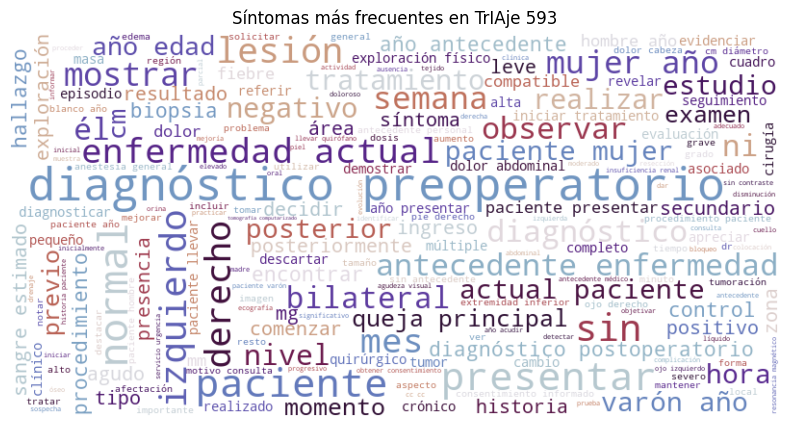

In [51]:
# Unir todo el texto procesado en un solo bloque gigante
texto_completo = " ".join(df_final['sintomas_procesados'])

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='twilight').generate(texto_completo)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Síntomas más frecuentes en TrIAje 593')
plt.show()

# Guardar la imagen de la nube de palabras
wordcloud.to_file('../data/external/nube_palabras_sintomas.png')